In [1]:
import os
import sys; sys.path.append(os.getcwd()+'/src')
from importlib import reload
import class_handler_v2 as classes; reload(classes)
import numpy as np
import pandas as pd

## Generate data to play with

In [2]:
from sklearn.datasets import load_breast_cancer
x, y = load_breast_cancer(return_X_y=True)
print(x.shape, y.shape)

(569, 30) (569,)


In [3]:
# Lets split into train and test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(455, 30) (455,) (114, 30) (114,)


## Load using new API

In [4]:
# Import classifiers
import class_handler_v2 as classes; reload(classes)
clfs = classes.Classifiers(verbose=1, method='complete')

Metod: 'complete'
Initialized classifiers:
	AdaBoost
	KNearestNeighbors
	LogReg


In [5]:
clfs.fit_classifiers(X_train, y_train, n_jobs=2)

Classifier AdaBoost trained (time: 0.00 min)
Classifier KNearestNeighbors trained (time: 0.00 min)
Classifier LogReg trained (time: 0.00 min)


In [6]:
y_train_pred = clfs.predict_classifiers(X_train)

In [7]:
# Evaulate performance on training data
print("Training scores:")
train_scores = clfs.classifier_performance(y_train_pred, y_train, metric='accuracy')
# Evaluate overfitting
print("Test scores:")
test_scores = clfs.classifier_performance(clfs.predict_classifiers(X_test), y_test, metric='accuracy')
# AdaBoost clearly overfits this dataset while LogiReg and KNN seem ok

Training scores:
log_loss: 0.0000 	 accuracy: 1.0000 	 AdaBoost
log_loss: 1.4423 	 accuracy: 0.9582 	 LogReg
log_loss: 2.0496 	 accuracy: 0.9407 	 KNearestNeighbors
Test scores:
log_loss: 1.5149 	 accuracy: 0.9561 	 KNearestNeighbors
log_loss: 1.5149 	 accuracy: 0.9561 	 LogReg
log_loss: 2.7268 	 accuracy: 0.9211 	 AdaBoost


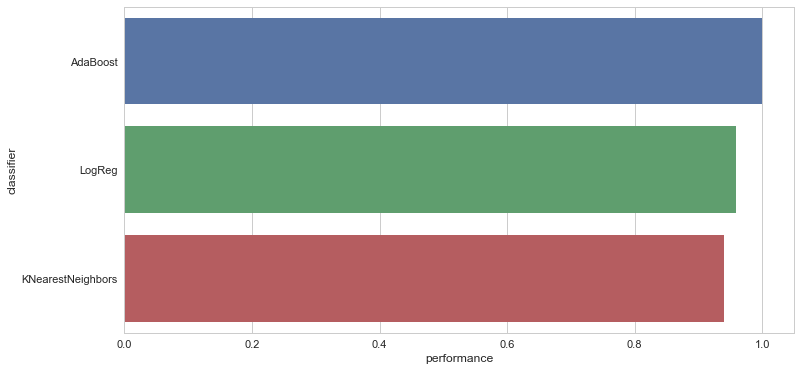

In [95]:
import visualize; reload(visualize)
from visualize import Visualizer as viz;
# This method expects a list of 2-tuples
viz().show_performance([tuple([x,y]) for x,y,_ in train_scores], fig_size=(12,6))

In [81]:
from sklearn.metrics import accuracy_score, log_loss
# Import classifiers
import class_handler_v2 as classes; reload(classes)
clfs = classes.Classifiers(verbose=0, method='complete')
clfs.verbose = 0
optims = clfs.optimize_classifiers(X_train, y_train, n_iter=4, n_jobs=-1)
print()
for name, clf in optims:
    #clf.fit(X_train, y_train)
    print(name, accuracy_score(clf.predict(X_train), y_train))
    print(name, accuracy_score(clf.predict(X_test), y_test)) 
    print()

Metod: 'complete'
Best mean score: 0.9604 (AdaBoost)
Best mean score: 0.9231 (KNearestNeighbors)
Best mean score: 0.9538 (LogReg)

AdaBoost 1.0
AdaBoost 0.947368421053

KNearestNeighbors 0.927472527473
KNearestNeighbors 0.964912280702

LogReg 0.964835164835
LogReg 0.964912280702



## Base class for algorithms

### Testing with adaboost

In [ ]:
import adaboost; reload(adaboost)
from adaboost import MetaAdaBoostClassifierAlgorithm
ada = MetaAdaBoostClassifierAlgorithm(random_state=0, base_estimator='logreg')
print(ada.get_info())
ada.cv_param_dist = ada._param_dist_dict()
print(ada.cv_param_dist)

# specify parameters and distributions to sample from
from sklearn.model_selection import RandomizedSearchCV
param_dist = ada.cv_param_dist
estimator = ada.estimator

# IT SEEMS THAT THE LOGISTIC REGRESSION CLASSIFIER TENDS TO OVERFIT...SHOULD LOWER n_iter IF USING THAT ALGO.
grid_search = RandomizedSearchCV(estimator, param_distributions=param_dist, n_iter=1, scoring='neg_log_loss',
                       cv=10, n_jobs=-1, verbose=0, error_score=0, return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best mean score: %.4f" % (grid_search.best_score_))
from sklearn.metrics import accuracy_score
print("Accuracy on test set: %.4f" % accuracy_score(y_test, grid_search.best_estimator_.predict(X_test))) 

grid_search.best_estimator_

### Testing with nearest neighbors algorithm

In [ ]:
import nearest_neighbors; reload(nearest_neighbors)
from nearest_neighbors import MetaKNearestNeighborClassifierAlgorithm
knn = MetaKNearestNeighborClassifierAlgorithm()
print(knn.get_info())
knn.cv_param_dist = knn._param_dist_dict()
print(type(knn.cv_param_dist))

# specify parameters and distributions to sample from
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
param_dist = knn.cv_param_dist
estimator = knn.estimator

In [ ]:
from pprint import pprint
pprint(param_dist.param_grid)
print("number of grids = %i" % len(param_dist.param_grid))

In [ ]:
results = []
for grid in param_dist.param_grid:
    grid_search = RandomizedSearchCV(estimator, param_distributions=grid, n_iter=2, scoring='accuracy',
                           cv=10, n_jobs=-1, verbose=0, error_score=0, return_train_score=True)
    #grid_search = GridSearchCV(estimator, param_grid=param_dist.param_grid, scoring='accuracy',
    #                       cv=10, n_jobs=-1, verbose=0, error_score=0, return_train_score=True)
    grid_search.fit(X_train, y_train)
    print("Best mean score: %.4f" % (grid_search.best_score_))
    from sklearn.metrics import accuracy_score
    print("Accuracy on test set: %.4f" % accuracy_score(y_test, grid_search.best_estimator_.predict(X_test))) 
    results.append((grid_search.best_score_, grid_search.best_estimator_))

print(results)

In [ ]:
# Import classifiers
clfs = classes.Classifiers(verbose=0, method='complete', num_clf=10)

# Fitting and tuning of parameters

We need a way of optimizing the hyper parameters of each selected algorithm. 

## Regular fitting (just train)

This is the basic building block: "fit_classifiers" loops over each algorithm and trains on data

In [ ]:
# Fit classifiers on data
clfs.fit_classifiers(X_train,y_train,1)

## Tune hyper parameters using cross validation

Scoring options:
* ['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc']

### Discrete and categorical variables (using scipy.stats)

In [ ]:
from sklearn.metrics import make_scorer
scorer = make_scorer(log_loss, greater_is_better=False)
scorer

In [ ]:
def neg_log_loss(y_true, y_pred):
    return -1.0 * log_loss(y_true, y_pred)
scorer = make_scorer(neg_log_loss)
scorer

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
# specify parameters and distributions to sample from
param_dist = {"max_depth": [1, 2, 3, 8, 12, None],
              "max_features": sp_randint(2, 15),
              "min_samples_split": sp_randint(2, 15),
              "min_samples_leaf": sp_randint(2, 15),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_estimators": [10, 100, 500]} 
estimator = RandomForestClassifier()
grid_search = RandomizedSearchCV(estimator, param_distributions=param_dist, n_iter=10, scoring=scorer,
                       cv=10, n_jobs=-1, verbose=0, error_score=0, return_train_score=True)
grid_search.fit(X_train, y_train)
#pd.DataFrame(grid_search.cv_results_).head()
print("Best mean score: %.4f" % (grid_search.best_score_))

from sklearn.metrics import accuracy_score
print("Accuracy on test set: %.4f" % accuracy_score(y_test, grid_search.best_estimator_.predict(X_test)))

### Continuous variable (using scipy.stats)

In [ ]:
from scipy.stats import uniform, gamma, lognorm
from sklearn.linear_model import LogisticRegression
param_dist = {"C": uniform(loc=0., scale=200.),
              "fit_intercept": [True, False],
              "penalty": ['l1', 'l2'],
              "max_iter": [50, 100, 150]}
estimator = LogisticRegression()
grid_search = RandomizedSearchCV(estimator, param_distributions=param_dist, n_iter=200, scoring='accuracy',
                       cv=10, n_jobs=-1, verbose=0, error_score=0, return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best mean score: %.4f" % (grid_search.best_score_))
print(grid_search.best_params_)

In [ ]:
# Predict on data (returns a list of (name, prediction) tuples for each classifier in repository)
preds = clfs.predict_classifiers(X_train)
clfs.verbose = 1 # Report progress if =1, else be quiet if =0.
# How well are we doing?
scores = clfs.classifier_performance(preds, y_train, metric='accuracy')

In [ ]:
preds = clfs.predict_classifiers(X_test)
clfs.verbose = 1 # Report progress if =1, else be quiet if =0.
# How well are we doing?
scores = clfs.classifier_performance(preds, y_test, metric='accuracy')

## Check correlations

In [ ]:
# Create an instance "correlation checking" classes
import class_handler as classes; reload(classes)
check = classes.CheckClassifierCorrelation(prediction_type='c_binary')
# Get names and correlation matrix
names_, corr_ = check.compute_correlation_matrix(preds)
# Plot correlation matrix (output depends on if plotting inline or not)
fig = check.plot_correlation_matrix(names_, corr_, fig_size=(16,10), rot=20, font_scale=1.1, file=os.getcwd()+"/corr.png")

In [ ]:
%matplotlib inline
fig